In [1]:
from sklearn import datasets, linear_model, metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

## Część 1

In [2]:
#ustawienia
time_multiplicator = 100
seed = 244810
samples = 2410

In [3]:
XY,C  = datasets.make_classification(n_features=2,n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed,  )

In [4]:
from sklearn.model_selection import train_test_split
XY_train, XY_test, C_train, C_test = train_test_split(XY, C, test_size=0.2, random_state=0)


In [5]:
# C_train = np.where(C_train==0, -1, C_train) 
# C_test = np.where(C_test==0, -1, C_test) 

In [6]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


XY_train = norm(XY_train)
XY_test = norm(XY_test)
C_train = norm(C_train)
C_test = norm(C_test)

### sklearn

In [7]:
#sklearn
sk_time = time.time()
for i in range(time_multiplicator):
    sk_ridge_ans= linear_model.RidgeClassifier(alpha=2e-16).fit(XY_train,C_train)
sk_time = (time.time() - sk_time)/time_multiplicator 


In [8]:
sk_pred = sk_ridge_ans.predict(XY_test)

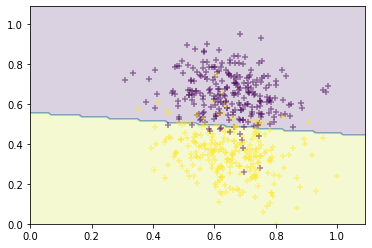

In [9]:
mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]

predict = sk_ridge_ans.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)

plt.contourf(mesh, mesh.T, predict, alpha=0.2)
#plt.scatter(XY_train[:, 0], XY_train[:, 1], c=C_train, marker="+", alpha=0.5)
plt.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

### Własna implementacja

In [10]:
#analityczna
def my_ridge(XY, C, k): 
    return np.linalg.pinv(XY.T @ XY + k * np.identity(len(XY.T))) @ XY.T @ C


In [11]:
my_time = time.time()
for i in range(time_multiplicator):
    my_ridge_ans = my_ridge(XY_train, C_train, 1e-100)
my_time = (time.time() - my_time)/time_multiplicator 


In [12]:
def my_prediction(theta, XY):
    Y_pred = XY @ theta
    mean = np.mean(Y_pred)
    
    ans = []
    
    for x in Y_pred:
        if x >= mean:
            ans.append(1.0)
        else:
            ans.append(0.0)
    
    return np.asarray(ans)

In [13]:
my_pred = my_prediction(my_ridge_ans, XY_test)
my_pred_print = my_prediction(my_ridge_ans, np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)

### Porównanie

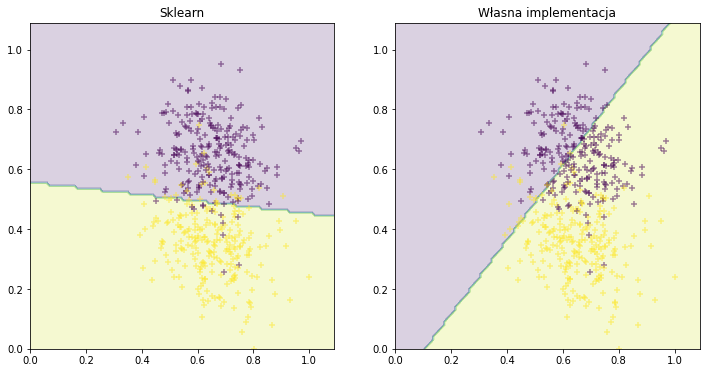

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

ax1.set_title("Sklearn")
ax1.contourf(mesh, mesh.T, predict, alpha=0.2)
ax1.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

ax2.set_title("Własna implementacja")
ax2.contourf(mesh, mesh.T, my_pred_print, alpha=0.2)
ax2.scatter(XY_test[:, 0], XY_test[:, 1], c=C_test+1, marker="+", alpha=0.5)

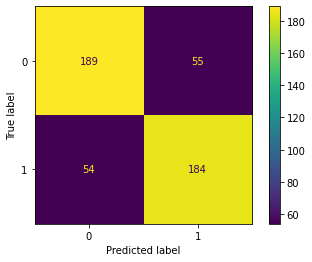

In [15]:
my_cm = metrics.confusion_matrix(C_test, my_pred)
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot()

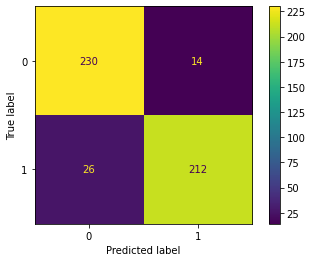

In [16]:
sk_cm = metrics.confusion_matrix(C_test, sk_pred)
sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
sk_disp.plot()

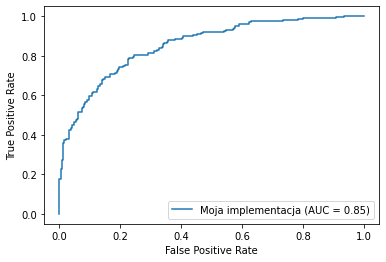

In [17]:

fpr, tpr, thresholds = metrics.roc_curve(C_test, XY_test @ my_ridge_ans)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Moja implementacja')
display.plot()

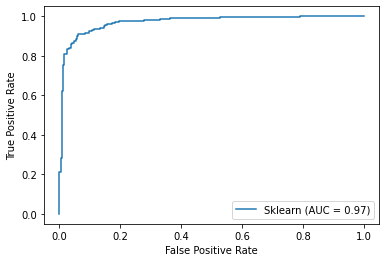

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(C_test, sk_ridge_ans.decision_function(XY_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
display.plot()

In [19]:
print("Sklearn czułość: ",sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]))
print("Wlasny  czułość: ",my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))
print()
print("Sklearn specyficzność: ",sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]))
print("Wlasny  specyficzność: ",my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]))
print()
print("Sklearn skuteczność: ",metrics.accuracy_score(sk_pred, C_test))
print("Wlasny  skuteczność: ",metrics.accuracy_score(my_pred, C_test))
print()
print("Sklearn czas: {:f}".format(sk_time))
print("Wlasny  czas: {:f}".format(my_time))

Sklearn czułość:  0.8984375
Wlasny  czułość:  0.7777777777777778

Sklearn specyficzność:  0.4796380090497738
Wlasny  specyficzność:  0.4932975871313673

Sklearn skuteczność:  0.91701244813278
Wlasny  skuteczność:  0.7738589211618258

Sklearn czas: 0.001140
Wlasny  czas: 0.000080


## Część 2

In [20]:
import pandas as pd 
cleveland = pd.read_csv('processed.cleveland.data', header=None, names=
                        ["age","sex","cp","trestbps","chol","fbs","restecg",
                         "thalach","exang","oldpeak","slope","ca","thal","num"])
cleveland = cleveland.apply(pd.to_numeric, errors='coerce')

print("ilość brakujących wartości: ",cleveland.isnull().sum(axis = 0).sum())
print(cleveland.isnull().sum(axis = 0))

ilość brakujących wartości:  6
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [21]:
cleveland = cleveland.dropna()

In [22]:
#zmienna przewidywana jako wartości binarne
cleveland.loc[cleveland['num'] > 0,'num'] = 1
cleveland.loc[cleveland['num'] == 0, 'num'] = -1
cleveland

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
297  57.0  0.0  4.0     140.0  241.0  0.0      0.0    123.0    1.0      0.2   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0   -1  
1      2.0  3.0   3.0    1  
2      2.0  2.0   7.0    1  
3      3.0  0.0   3.0   -1  
4      1.0  0.0   3.0   -1  
..     ...  ...   ...  ...  
297    2.0  0.0   7.0    1  
298    2.0  0.0   7.0    1  
299    2.0  2.0   7.0    1  
300    2.0  1.0   7.0    1  
301    2.0  1.0   3.0    1  

[297 rows x 14 columns]

In [23]:
#cleveland.describe()

In [24]:
# na podstawie heart-disease.name
# 3  (age)      ciągła      
# 4  (sex)      kategoryczna 
# 9  (cp)       kategoryczna 
# 10 (trestbps) ciągła
# 12 (chol)     ciągła
# 16 (fbs)      kategoryczna
# 19 (restecg)  kategoryczna
# 32 (thalach)  ciągła
# 38 (exang)    kategoryczna
# 40 (oldpeak)  dyskretna
# 41 (slope)    kategoryczna
# 44 (ca)       kategoryczna
# 51 (thal)     kategoryczna
# 58 (num)      kategoryczna

In [42]:
stat = pd.Series({
    'age_mean':cleveland['age'].mean(),
    'age_min':cleveland['age'].min(),
    'age_max':cleveland['age'].max(),
    'age_std':cleveland['age'].std(),
    
    'sex_dom':cleveland['sex'].mode()[0],
    
    'cp_dom':cleveland['cp'].mode()[0],
    
    'trestbps_mean':cleveland['trestbps'].mean(),
    'trestbps_min':cleveland['trestbps'].min(),
    'trestbps_max':cleveland['trestbps'].max(),
    'trestbps_std':cleveland['trestbps'].std(),
    
    'chol_mean':cleveland['chol'].mean(),
    'chol_min':cleveland['chol'].min(),
    'chol_max':cleveland['chol'].max(),
    'chol_std':cleveland['chol'].std(),
    
    'fbs_dom':cleveland['fbs'].mode()[0],
    
    'restecg_dom':cleveland['restecg'].mode()[0],
        
    'thalach_mean':cleveland['thalach'].mean(),
    'thalach_min':cleveland['thalach'].min(),
    'thalach_max':cleveland['thalach'].max(),
    'thalach_std':cleveland['thalach'].std(),
    
    'exang_dom':cleveland['exang'].mode()[0],
    
    'oldpeak_dom':cleveland['oldpeak'].mode()[0],
    'oldpeak_mean':cleveland['oldpeak'].mean(),
    
    'slope_dom':cleveland['slope'].mode()[0],
    
    'ca_dom':cleveland['ca'].mode()[0],
    
    'thal_dom':cleveland['thal'].mode()[0],
    
    'num_dom':cleveland['num'].mode()[0],
    
})

stat.to_frame()

0
age_mean        54.542088
age_min         29.000000
age_max         77.000000
age_std          9.049736
sex_dom          1.000000
cp_dom           4.000000
trestbps_mean  131.693603
trestbps_min    94.000000
trestbps_max   200.000000
trestbps_std    17.762806
chol_mean      247.350168
chol_min       126.000000
chol_max       564.000000
chol_std        51.997583
fbs_dom          0.000000
restecg_dom      0.000000
thalach_mean   149.599327
thalach_min     71.000000
thalach_max    202.000000
thalach_std     22.941562
exang_dom        0.000000
oldpeak_dom      0.000000
oldpeak_mean     1.055556
slope_dom        1.000000
ca_dom           0.000000
thal_dom         3.000000
num_dom         -1.000000

In [26]:
# klasa = 'age'

# plt.hist(cleveland.query("num == 1")[klasa].to_numpy(), color='r',alpha=0.5,label="chory", )
# plt.hist(cleveland.query("num == -1")[klasa].to_numpy(),color='g', alpha=0.5, label="zdrowy",)
# plt.title(klasa)
# plt.xlabel('Wartość cechy')
# plt.ylabel('Liczba przypadków')
# plt.legend()

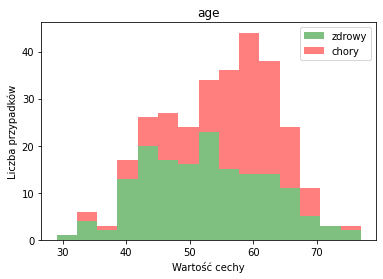

In [27]:
klasa = 'age'
podzial = 15
x,y = [],[]
zdrowy=cleveland.query("num == -1")[klasa]
chory=cleveland.query("num == 1")[klasa]

plt.hist([zdrowy,chory],podzial, stacked=True, color=['g','r'], alpha=0.5, label=['zdrowy','chory'])
plt.title(klasa)
plt.xlabel('Wartość cechy')
plt.ylabel('Liczba przypadków')
plt.legend()

In [28]:
cleveland.corr()

age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.092399  0.110471  0.290476  0.202644  0.132062   
sex      -0.092399  1.000000  0.008908 -0.066340 -0.198089  0.038850   
cp        0.110471  0.008908  1.000000 -0.036980  0.072088 -0.057663   
trestbps  0.290476 -0.066340 -0.036980  1.000000  0.131536  0.180860   
chol      0.202644 -0.198089  0.072088  0.131536  1.000000  0.012708   
fbs       0.132062  0.038850 -0.057663  0.180860  0.012708  1.000000   
restecg   0.149917  0.033897  0.063905  0.149242  0.165046  0.068831   
thalach  -0.394563 -0.060496 -0.339308 -0.049108 -0.000075 -0.007842   
exang     0.096489  0.143581  0.377525  0.066691  0.059339 -0.000893   
oldpeak   0.197123  0.106567  0.203244  0.191243  0.038596  0.008311   
slope     0.159405  0.033345  0.151079  0.121172 -0.009215  0.047819   
ca        0.362210  0.091925  0.235644  0.097954  0.115945  0.152086   
thal      0.126586  0.383652  0.268500  0.138183  0.010859  0.062209   
num       0.227075  0.278467  0.408945  0.153490  0.080285  0.003167   

           restecg   thalach     exang   oldpeak     slope        ca  \
age       0.149917 -0.394563  0.096489  0.197123  0.159405  0.362210   
sex       0.033897 -0.060496  0.143581  0.106567  0.033345  0.091925   
cp        0.063905 -0.339308  0.377525  0.203244  0.151079  0.235644   
trestbps  0.149242 -0.049108  0.066691  0.191243  0.121172  0.097954   
chol      0.165046 -0.000075  0.059339  0.038596 -0.009215  0.115945   
fbs       0.068831 -0.007842 -0.000893  0.008311  0.047819  0.152086   
restecg   1.000000 -0.072290  0.081874  0.113726  0.135141  0.129021   
thalach  -0.072290  1.000000 -0.384368 -0.347640 -0.389307 -0.268727   
exang     0.081874 -0.384368  1.000000  0.289310  0.250572  0.148232   
oldpeak   0.113726 -0.347640  0.289310  1.000000  0.579037  0.294452   
slope     0.135141 -0.389307  0.250572  0.579037  1.000000  0.109761   
ca        0.129021 -0.268727  0.148232  0.294452  0.109761  1.000000   
thal      0.018795 -0.274831  0.326927  0.344976  0.279688  0.256382   
num       0.166343 -0.423817  0.421355  0.424052  0.333049  0.463189   

              thal       num  
age       0.126586  0.227075  
sex       0.383652  0.278467  
cp        0.268500  0.408945  
trestbps  0.138183  0.153490  
chol      0.010859  0.080285  
fbs       0.062209  0.003167  
restecg   0.018795  0.166343  
thalach  -0.274831 -0.423817  
exang     0.326927  0.421355  
oldpeak   0.344976  0.424052  
slope     0.279688  0.333049  
ca        0.256382  0.463189  
thal      1.000000  0.526640  
num       0.526640  1.000000

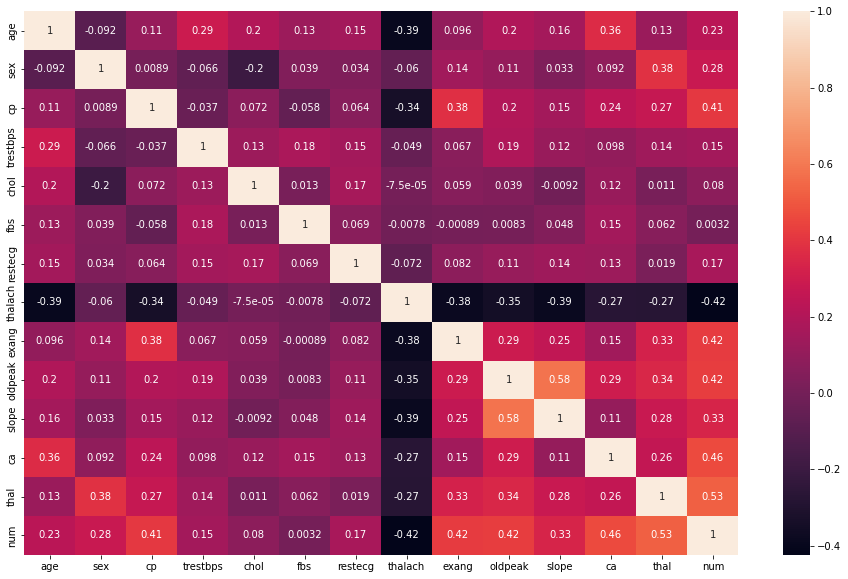

In [29]:
import seaborn as sn
plt.figure(figsize = (16,10))
sn.heatmap(cleveland.corr(),annot=True, )
plt.show()

In [30]:
import math
corr = cleveland.corr()['num']
corr = corr.abs()
corr.sort_values()

fbs         0.003167
chol        0.080285
trestbps    0.153490
restecg     0.166343
age         0.227075
sex         0.278467
slope       0.333049
cp          0.408945
exang       0.421355
thalach     0.423817
oldpeak     0.424052
ca          0.463189
thal        0.526640
num         1.000000
Name: num, dtype: float64

### Część 3



In [31]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

x=cleveland.drop(columns='num')
y= cleveland['num']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

X_train = norm(X_train)
X_test = norm(X_test)
y_train = norm(y_train)
y_test = norm(y_test)

c:\python\python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\python\python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [39]:

model = linear_model.RidgeClassifier()
sfsmodel = sfs(model, n_features_to_select=4)
sfsmodel.fit(X_train,y_train)

sfsmodel.get_feature_names_out()

array(['cp', 'thalach', 'ca', 'thal'], dtype=object)

In [32]:
#sklearn
cle_sk_time = time.time()
for i in range(time_multiplicator):
    cle_sk_ans = linear_model.RidgeClassifier().fit(X_train, y_train)
cle_sk_time = (time.time() - cle_sk_time)/time_multiplicator 

In [33]:
cle_sk_pred = cle_sk_ans.predict(X_test)

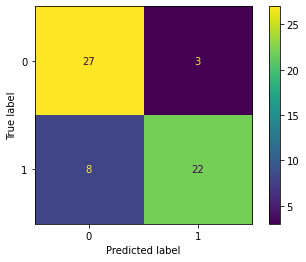

In [34]:
cle_cm=metrics.confusion_matrix(y_test,cle_sk_pred)
cle_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cle_cm)
cle_disp.plot()

In [35]:
#analityczna

cle_my_time = time.time()
for i in range(time_multiplicator):
    cle_my_ans = my_ridge(X_train, y_train, 1e-100)
cle_my_time = (time.time() - cle_my_time)/time_multiplicator 
#[,,,,,]
cle_my_ans = cle_my_ans.to_numpy()



In [37]:
def my_prediction2(theta, XY):
    Y_pred = XY @ theta
    mean = np.mean(Y_pred)
    
    ans = []
    
    for x in Y_pred:
        if x >= 0:
            ans.append(1.0)
        else:
            ans.append(-1)
    
    return np.asarray(ans)

cle_my_pred = my_prediction2(cle_my_ans.reshape(1,len(cle_my_ans)), y_test.to_numpy().reshape(-1,1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
y_test.to_numpy().reshape(-1,1) @ cle_my_ans.reshape(1,len(cle_my_ans))

In [38]:
print("Sklearn czułość: ",cle_cm[0][0]/(cle_cm[0][0]+cle_cm[1][0]))
print("Wlasny  czułość: ",my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))
print()
print("Sklearn specyficzność: ",cle_cm[1][1]/(cle_cm[0][0]+cle_cm[1][1]))
print("Wlasny  specyficzność: ",my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]))
print()
print("Sklearn skuteczność: ",metrics.accuracy_score(cle_sk_pred, y_test))
print("Wlasny  skuteczność: ",metrics.accuracy_score(my_pred, C_test))
print()
print("Sklearn czas: {:f}".format(my_time))
print("Wlasny  czas: {:f}".format(cle_sk_time))

Sklearn czułość:  0.7714285714285715
Wlasny  czułość:  0.7777777777777778

Sklearn specyficzność:  0.4489795918367347
Wlasny  specyficzność:  0.4932975871313673

Sklearn skuteczność:  0.8166666666666667
Wlasny  skuteczność:  0.7738589211618258

Sklearn czas: 0.000080
Wlasny  czas: 0.001480
